In [ ]:
# In this Notebook I am going to generate an estimate about the average LTV of players 

# In general, there are two broad approaches to modelling the LTV problem:
# 1-Historical Approach:
#   -Aggregate Model  —  calculating the LTV by using the average revenue per player based on past transactions. This method gives us a single value for the TLV.
#    -Cohort Model  —  grouping the customers into different cohorts based on the transaction date, etc., and calculate the average revenue per cohort. This method gives TLV value for each cohort.
# 2-Predictive Approach:
#  -Machine Learning Model  —  using regression techniques to fit on past data to predict the LTV.
#  -Probabilistic Model  —  it tries to fit a probability distribution to the data and estimates the future count of transactions and monetary value for each transaction.


#  In this Notebook I will use the Probabilistic Model considering two categorical Features (Region and Device)

# I will calculate the Estimated LTV using the following formula
# Expected LTV =average player lifespan x average transactions per period x average transaction amount ($)

# This Notebook will be presented as follows:
# I- Importing Data and Cleaning
# II- Exploring Data and Features 
# III- Data Aggregation
# IV- Estimating LTV
# V- Conclusion

In [2]:
# I- Import Data

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm

In [57]:
iap_Df = pd.read_csv (r'iap_table.csv')
iap_Df.head()

,Unnamed: 0,player_id,iap_amt,iap_dt
0,0,6467b385-589e-482b-8826-3cda30ba5f69,2.0,1/13/2020
1,1,6467b385-589e-482b-8826-3cda30ba5f69,1.9,1/15/2020
2,2,6467b385-589e-482b-8826-3cda30ba5f69,1.4,1/20/2020
3,3,6467b385-589e-482b-8826-3cda30ba5f69,6.8,1/27/2020
4,4,6467b385-589e-482b-8826-3cda30ba5f69,4.3,1/30/2020


In [61]:
# View data for Cleaning purpose

In [59]:
player_Df = pd.read_csv (r'players_table.csv')
player_Df.head()

,Unnamed: 0,player_id,geo_region,device_type,install_dt
0,0,6467b385-589e-482b-8826-3cda30ba5f69,NAm,iphone,1/7/2020
1,1,ecdcfde8-fdf4-4954-8bda-0489d22e0416,NAm,iphone,12/13/2020
2,2,3eb13468-6a4e-4baa-9251-f914629e0d80,NAm,iphone,2/13/2021
3,3,3356c5af-c149-4e08-9771-8a6b8bd5268f,NAm,iphone,1/12/2020
4,4,8d42632b-b9e7-4d98-8f91-0a09847d8cbf,NAm,iphone,5/29/2020


In [60]:
#number of players
player_Df['player_id'].nunique()

73595

In [62]:
print(player_Df.isnull().sum())

Unnamed: 0     0
player_id      0
geo_region     0
device_type    0
install_dt     0
dtype: int64


In [63]:
print(iap_Df.isnull().sum())

Unnamed: 0    0
player_id     0
iap_amt       0
iap_dt        0
dtype: int64


In [64]:
# Check if all Players had an in app purchase
iap_Df['player_id'].nunique()

1277

In [ ]:
### it is obvious that most of the players are not in-app-purchase

In [ ]:
# II- Exploring Data and Features Effect

In [65]:
## Select Usefull Data and Variables

In [58]:
iap_Df.describe()

,Unnamed: 0,iap_amt
count,13788.000000,13788.000000
mean,7084.260226,13.886728
std,4189.588005,57.737482
min,0.000000,1.000000
25%,3446.750000,1.400000
50%,6893.500000,2.200000
75%,10849.250000,4.900000
max,14353.000000,500.000000


In [66]:
iap_Df.head()

,Unnamed: 0,player_id,iap_amt,iap_dt
0,0,6467b385-589e-482b-8826-3cda30ba5f69,2.0,1/13/2020
1,1,6467b385-589e-482b-8826-3cda30ba5f69,1.9,1/15/2020
2,2,6467b385-589e-482b-8826-3cda30ba5f69,1.4,1/20/2020
3,3,6467b385-589e-482b-8826-3cda30ba5f69,6.8,1/27/2020
4,4,6467b385-589e-482b-8826-3cda30ba5f69,4.3,1/30/2020


In [69]:
## 1std find Cumulative sum for each Player in app purchase table
iap_Df['iap_dt'] = pd.to_datetime(iap_Df['iap_dt'])
cum_sum_Df=iap_Df.sort_values(['iap_dt'],ascending=False).reset_index(drop=True)
cum_sum_Df["cum_sum"]=cum_sum_Df.groupby(['player_id'])['iap_amt'].cumsum(axis=0)
cum_sum_Df.drop(['Unnamed: 0'], axis = 1, inplace = True)
cum_sum_Df.sample(5)

,player_id,iap_amt,iap_dt,cum_sum
2610,c875ecaa-6fae-4904-8e63-3b6cad7cd036,9.6,2021-01-24,64.3
11163,9d8b8118-c0fe-4cd4-9a65-95c27f37ba46,93.9,2020-06-03,95.0
11290,7824642e-cb7f-4a84-b157-6733b6baf4a8,15.2,2020-05-29,847.7
12758,6f251b1d-4e2a-4a90-b90b-aff1437cf18c,1.6,2020-03-26,4.7
3970,28c3dc54-d094-4ba7-8c4e-c58353fb2154,1.2,2020-12-20,427.8


In [70]:
# 2nd join player data with purchase data and fill player cum som with no purchases by zero's
cum_sum_Df = player_Df.merge(cum_sum_Df,how='left', left_on=['player_id'], right_on=['player_id'])
cum_sum_Df['cum_sum'] = cum_sum_Df['cum_sum'].fillna(0)
cum_sum_Df['iap_amt'] = cum_sum_Df['iap_amt'].fillna(0)
cum_sum_Df['iap_dt'] = cum_sum_Df['iap_dt'].fillna(0)
cum_sum_Df['iap_dt'] = cum_sum_Df.apply(lambda row : row['install_dt'] if row['iap_dt']==0 else row['iap_dt'],axis=1)
cum_sum_Df.drop(['Unnamed: 0'], axis = 1, inplace = True)
cum_sum_Df['install_dt'] = pd.to_datetime(cum_sum_Df['install_dt'])
cum_sum_Df['iap_dt'] = pd.to_datetime(cum_sum_Df['iap_dt'])
cum_sum_Df.sample(5)

,player_id,geo_region,device_type,install_dt,iap_amt,iap_dt,cum_sum
48873,c4b435c0-39bc-46c6-9a78-4f646c3a8e80,NAm,android,2020-07-01,0.0,2020-07-01,0.0
68417,0f2df732-0174-4fca-93d9-00883e46dc0b,Europe,android,2020-06-16,0.0,2020-06-16,0.0
11617,6e17b348-2253-4a7b-88c6-2e58b7fac0d5,NAm,iphone,2020-12-19,0.0,2020-12-19,0.0
14191,1e4f6bc4-9b6a-4e3b-a41a-6ed3050c7d3a,Europe,iphone,2020-05-14,2.6,2021-03-24,2.6
55540,5847c50d-494a-4e09-af93-6a423cfbd659,JapanPlus,android,2020-07-22,0.0,2020-07-22,0.0


In [71]:
## Data Exploration

In [72]:
#1st view purchase effect across region and devices

In [42]:
# region effect on purchases
geo_sum_Df=cum_sum_Df.sort_values(['iap_dt'],ascending=False).reset_index(drop=True)
geo_sum_Df=geo_sum_Df.groupby(['iap_dt','geo_region'],as_index=False).mean()
geo_sum_Df.sample(5)


,iap_dt,geo_region,iap_amt,cum_sum
1847,2021-03-13,JapanPlus,14.466667,37.700000
594,2020-05-28,NAm,0.892453,11.543396
1282,2020-11-16,NAm,0.935484,38.727419
519,2020-05-09,ROW,0.570000,17.738000
425,2020-04-16,JapanPlus,0.214286,3.133333


Text(0, 0.5, 'Avg Cumsum - axis')

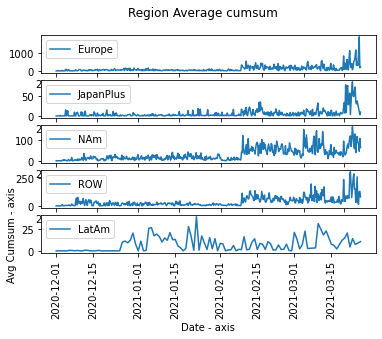

In [18]:
# plot the graphs
fig, axs = plt.subplots(geo_sum_Df['geo_region'].nunique())
fig.suptitle('Region Average cumsum')

for i,region in enumerate(geo_sum_Df['geo_region'].unique()):
    x=geo_sum_Df[geo_sum_Df['geo_region']==region]['iap_dt']
    y=geo_sum_Df[geo_sum_Df['geo_region']==region]['cum_sum']
    # plotting the region line  points 
    axs[i].plot(x, y, label = region)
    axs[i].label= region
    axs[i].legend()

plt.xticks(rotation='vertical')
plt.xlabel('Date - axis')
plt.ylabel('Avg Cumsum - axis')


In [ ]:
### from the Graphs we can conclude that some regions affectings purchases more than others and mostly after 2021-02

In [43]:
# Device Type Effect on purchases
dev_sum_Df=cum_sum_Df.sort_values(['iap_dt'],ascending=False).reset_index(drop=True)
dev_sum_Df=dev_sum_Df.groupby(['iap_dt','device_type'],as_index=False).mean()
dev_sum_Df.sample(5)

,iap_dt,device_type,iap_amt,cum_sum
575,2020-10-14,iphone,9.444737,159.278070
812,2021-02-10,android,0.277500,1.945000
207,2020-04-13,iphone,2.782353,183.829412
640,2020-11-16,android,0.253704,5.723148
771,2021-01-20,iphone,13.821818,122.761818


Text(0, 0.5, 'Avg Cumsum - axis')

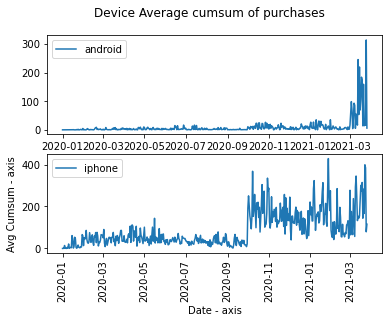

In [20]:
# 
fig, axs = plt.subplots(dev_sum_Df['device_type'].nunique())
fig.suptitle('Device Average cumsum of purchases')

for i,region in enumerate(dev_sum_Df['device_type'].unique()):
    x=dev_sum_Df[dev_sum_Df['device_type']==region]['iap_dt']
    y=dev_sum_Df[dev_sum_Df['device_type']==region]['cum_sum']
    # plotting the region line  points 
    axs[i].plot(x, y, label = region)
    axs[i].label= region
    axs[i].legend()
    plt.xticks(rotation='vertical')


plt.xlabel('Date - axis')
plt.ylabel('Avg Cumsum - axis')

In [ ]:
### Referring to the previous graph it is obvious that device type affects the in purchase sum

In [ ]:
## Lets collect useful features into one table 

In [ ]:
#1-average customer lifespan
#2-average transactions per period
#3- transaction amount ($)
#Knowing these three factors, we can simply multiply them together to calculate lifetime value.

In [24]:
cum_sum_Df['device_type'].unique()

array(['iphone', 'android'], dtype=object)

In [73]:
# lets convert device type and geo region into categoical values

device_type = pd.Categorical(cum_sum_Df['device_type'],
                           categories=cum_sum_Df['device_type'].unique(), ordered=True)
cum_sum_Df['device_type'] = device_type

geo_region = pd.Categorical(cum_sum_Df['geo_region'],
                           categories=cum_sum_Df['geo_region'].unique(), ordered=True)
cum_sum_Df['geo_region'] = geo_region

cum_sum_Df.sample(5)

,player_id,geo_region,device_type,install_dt,iap_amt,iap_dt,cum_sum
13996,15a24012-0457-4549-a55e-974d0053b19f,NAm,iphone,2020-04-27,0.0,2020-04-27,0.0
77540,680bdf7b-e60b-4396-9a38-87215aa85edf,ROW,android,2020-04-07,0.0,2020-04-07,0.0
71522,9138387c-bfd6-49f7-9051-8e15a0787e82,Europe,android,2020-04-10,0.0,2020-04-10,0.0
6448,170b8745-b735-450e-acab-3d267e4a558d,NAm,iphone,2020-11-13,0.0,2020-11-13,0.0
59471,51c438c8-f48c-46eb-baf2-413ce0455247,JapanPlus,android,2020-11-02,0.0,2020-11-02,0.0


In [ ]:
# Converting Date to month Cohorts
#The easiest way to do this is to convert the iap_dt column to a transaction month that just outputs the month that the transaction took place.

In [77]:
date_mapper = {
    date: pd.to_datetime(date).month for date in cum_sum_Df['iap_dt'].unique()
}
month = cum_sum_Df['iap_dt'].map(date_mapper)
cum_sum_Df['iap_month'] = month


In [277]:
cum_sum_Df.head(5)

,player_id,geo_region,device_type,install_dt,iap_amt,iap_dt,cum_sum,month,iap_month
0,6467b385-589e-482b-8826-3cda30ba5f69,NAm,iphone,2020-01-07,2.5,2020-02-23,2.5,2,2
1,6467b385-589e-482b-8826-3cda30ba5f69,NAm,iphone,2020-01-07,9.1,2020-02-22,11.6,2,2
2,6467b385-589e-482b-8826-3cda30ba5f69,NAm,iphone,2020-01-07,10.6,2020-02-20,22.2,2,2
3,6467b385-589e-482b-8826-3cda30ba5f69,NAm,iphone,2020-01-07,1.1,2020-02-16,23.3,2,2
4,6467b385-589e-482b-8826-3cda30ba5f69,NAm,iphone,2020-01-07,1.3,2020-02-02,24.6,2,2


In [ ]:
# Now, we can organize, filter, and manipulate our data using the iap_month.

In [ ]:
#Ranking  Categories

In [ ]:
# we have  to consider that a player can use several devices and play from several countries

In [90]:
# example of specific customer used ctegory info
print(cum_sum_Df.loc[cum_sum_Df.player_id == '0001de24-b022-45b9-9c84-403a9934b01e']['geo_region'].value_counts())
print(cum_sum_Df.loc[cum_sum_Df.player_id == '0001de24-b022-45b9-9c84-403a9934b01e']['geo_region'].sort_values().iloc[0])
print(cum_sum_Df.loc[cum_sum_Df.player_id == '0001de24-b022-45b9-9c84-403a9934b01e']['device_type'].value_counts())
print(cum_sum_Df.loc[cum_sum_Df.player_id == '0001de24-b022-45b9-9c84-403a9934b01e']['device_type'].sort_values().iloc[0])

ROW          47
LatAm         0
JapanPlus     0
Europe        0
NAm           0
Name: geo_region, dtype: int64
ROW
iphone     47
android     0
Name: device_type, dtype: int64
iphone


In [ ]:
#To demonstrate how we’ll use this, let’s identify a player based on their highest value within Catigory. 

In [94]:
def highest_cat(p_id, df=cum_sum_Df,cat='geo_region'):
    cat = df.loc[df.player_id == p_id][cat].sort_values().iloc[0]
    return cat

reg_mapper = {
    player_id: highest_cat(player_id,cum_sum_Df,cat='geo_region') for player_id in cum_sum_Df['player_id'].unique()
}


In [95]:
dev_mapper = {
    player_id: highest_cat(player_id,cum_sum_Df,cat='device_type') for player_id in cum_sum_Df['player_id'].unique()
}

In [98]:
# save data for unexpected problems
with open('mappers.pickle', 'wb') as f:
    pickle.dump([reg_mapper,dev_mapper], f)

In [96]:
# III- Data Agregation

In [ ]:
## reload data

In [104]:
with open('mappers.pickle', 'rb') as f:
    reg_mapper,dev_mapper = pickle.load(f)

In [ ]:
#In short, we’ve made a new dataframe  that has an index of each unique player id
#and columns consisting of the total transaction amount, the total number of transactions,
#and the unique months in which a transaction was made for each player.

In [99]:
player_data_df = cum_sum_Df.groupby(['player_id']).agg({
        'iap_amt': ['sum', 'count'],
        'iap_month': [pd.Series.nunique]
    })

In [105]:
player_data_df['most_region'] = player_data_df.index.map(reg_mapper)
player_data_df['most_dev'] = player_data_df.index.map(dev_mapper)

In [106]:
### Then, we can create new columns for lifespan, avg_trn_per_mth, and avg_trn_amt for each of our players:

In [108]:
player_data_df.head()

iap_amt       iap_month most_region  \
                                         sum count   nunique               
player_id                                                                  
0001734a-66e8-44a1-bcea-703876804b2a     0.0     1         1         ROW   
0001de24-b022-45b9-9c84-403a9934b01e   441.7    47        11         ROW   
0001fffa-837a-461e-8aef-1e8223155f25     0.0     1         1         NAm   
0002a7ad-1a4a-499d-b6ed-b370bcc9340f     0.0     1         1      Europe   
0003024c-b5c7-45cd-806e-ff96bac90245     0.0     1         1   JapanPlus   

                                     most_dev  
                                               
player_id                                      
0001734a-66e8-44a1-bcea-703876804b2a   iphone  
0001de24-b022-45b9-9c84-403a9934b01e   iphone  
0001fffa-837a-461e-8aef-1e8223155f25  android  
0002a7ad-1a4a-499d-b6ed-b370bcc9340f  android  
0003024c-b5c7-45cd-806e-ff96bac90245  android

In [109]:
player_data_df['lifespan'] = player_data_df[('iap_month', 'nunique')]
player_data_df['avg_trn_per_mth'] = player_data_df[('iap_amt', 'count')] / player_data_df['lifespan']
player_data_df['avg_trn_amt'] = player_data_df[('iap_amt', 'sum')] / player_data_df[('iap_amt', 'count')]

In [151]:
player_data_df.head()

iap_amt       iap_month most_region  \
                                         sum count   nunique               
player_id                                                                  
0001734a-66e8-44a1-bcea-703876804b2a     0.0     1         1         ROW   
0001de24-b022-45b9-9c84-403a9934b01e   441.7    47        11         ROW   
0001fffa-837a-461e-8aef-1e8223155f25     0.0     1         1         NAm   
0002a7ad-1a4a-499d-b6ed-b370bcc9340f     0.0     1         1      Europe   
0003024c-b5c7-45cd-806e-ff96bac90245     0.0     1         1   JapanPlus   

                                     most_dev lifespan avg_trn_per_mth  \
                                                                         
player_id                                                                
0001734a-66e8-44a1-bcea-703876804b2a   iphone        1        1.000000   
0001de24-b022-45b9-9c84-403a9934b01e   iphone       11        4.272727   
0001fffa-837a-461e-8aef-1e8223155f25  android        1        1.000000   
0002a7ad-1a4a-499d-b6ed-b370bcc9340f  android        1        1.000000   
0003024c-b5c7-45cd-806e-ff96bac90245  android        1        1.000000   

                                     avg_trn_amt  
                                                  
player_id                                         
0001734a-66e8-44a1-bcea-703876804b2a    0.000000  
0001de24-b022-45b9-9c84-403a9934b01e    9.397872  
0001fffa-837a-461e-8aef-1e8223155f25    0.000000  
0002a7ad-1a4a-499d-b6ed-b370bcc9340f    0.000000  
0003024c-b5c7-45cd-806e-ff96bac90245    0.000000

In [112]:
#### The avg_trn_per_mth column is the count of transactions per player divided by their lifespan.
#### For example, if a player made 20 transactions in their lifetime and had a lifespan of 4 months, they make on average 5 transactions per month.

In [113]:
# IV- Estimating LTV for New Users

In [ ]:
# We have already organized our dataframe to include the lifespan, average transactions per month, and average transaction amount for each of our players.
# Calculating the lifetime value is now as simple as taking the average of each of those columns and multiplying them together.

In [252]:
def ltv(df,cat_dev=None,cat_reg=None):
    if cat_dev and cat_reg:
        df = df.loc[(df['most_dev'] == cat_dev) & (df['most_region'] == cat_reg) ]
    ltv_dict = {
          'avg_lifespan': round(df['lifespan'].mean(), 1),
          'avg_trn_per_mth': round(df['avg_trn_per_mth'].mean(), 1),
          'avg_trn_amt': round(df['avg_trn_amt'].mean(), 2),
          'ltv': None
      }
    # Calculate Estimated LTV
    ltv_dict['ltv'] = round(ltv_dict['avg_lifespan'] * ltv_dict['avg_trn_per_mth'] * ltv_dict['avg_trn_amt'], 2)
    # calculating the Confidence interval 
    se=pd.Series.sem((df['lifespan']*df['avg_trn_per_mth']*df['avg_trn_amt']))
    ltv_dict['lower_CI']= ltv_dict['ltv'] - 1.96 *se
    ltv_dict['upper_CI']= ltv_dict['ltv']+ 1.96* se
    return ltv_dict

In [253]:
## Confidence interval
## Confidence interval= mean +|- Z_Score * Standard_Error
## z-score for a 95% confidence interval for a large enough sample is 1.96
## Standard_Error= SD/sqrt(number of observations)


In [254]:
ltv_all = ltv(player_data_df)
ltv_android_NAm = ltv(player_data_df)
print(f"The lifetime value of our android plyers from US and Canada is: {ltv_android_NAm['ltv']}")

The lifetime value of our android plyers from US and Canada is: 0.21


In [255]:
# Generate Output Table

In [275]:
regions= player_data_df['most_region'].unique()
devices= player_data_df['most_dev'].unique()
LTV_list=[]
reg_list=[]
dev_list=[]
LTV_Upper_list=[]
LTV_Lower_list=[]
for reg in regions:
    for dev in devices:
        dic_ltv=ltv(player_data_df, dev,reg)
        LTV_list.append(dic_ltv['ltv'])
        LTV_Upper_list.append(dic_ltv['upper_CI'])
        LTV_Lower_list.append(dic_ltv['lower_CI'])
        reg_list.append(reg)
        dev_list.append(dev)


results = pd.DataFrame(data={'device_type':dev_list,'georegion':reg_list, 
                             'LTV':LTV_list,'Upper_CI':LTV_Upper_list,'Lower_CI':LTV_Lower_list})
results[['device_type','georegion','LTV']].to_csv(r'file_results.csv', index = False, header = True)

In [278]:
results[['device_type','georegion','LTV','Upper_CI']]

,device_type,georegion,LTV,Upper_CI
0,iphone,ROW,0.19,1.413246
1,android,ROW,0.02,0.059614
2,iphone,NAm,0.59,1.871391
3,android,NAm,0.20,0.554155
4,iphone,Europe,0.42,3.905900
5,android,Europe,0.26,1.076023
6,iphone,JapanPlus,0.25,1.605546
7,android,JapanPlus,0.05,0.191579
8,iphone,LatAm,0.31,4.235128
9,android,LatAm,0.02,0.069123


In [ ]:
# In general The LTV is Low since most of the users are not in do no't purchase
# from the results we can find that it is maximum when using iPhone device from Canada and USA
# and it is minimum LTV for Players from LatAm (Latin America), ROW (Rest of
#Asia, Middle East, Africa, Oceania, island nations, other uncategorized) who uses Android based devices.

In [ ]:
# V- Conclusion
#The obtained LTV estimate is done using a statistical approach which works well, however, 
#Machine learning is worth to try and it may result in more accurate estimations. 
#Considering only two categorical dependent variables is not enough to rely on this estimate and I recommend
#to add the time feature as additional dependent variables that can improve the results and obtain more reliable 
# actionable insights.